# Extra Credit Question

# Task 1: Analysis of Counts per day for TMAX

Plot for counts of measurement per day for TMAX is shown below. In this analysis, we want to explain two things:
1. Why is there a sudden dip at the end of every month in the plot.
2. Why is there such a big dip in counts at the begining and end of a year.

In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
data_dir = "../../Data/Weather/"

           TMIN = Minimum temperature (tenths of degrees C)
mean:44.531018 std:109.933072 low1000:-350.000000 low100:-245.000000 high100:239.000000 high1000:278.000000
 	   TOBS = Temperature at the time of observation (tenths of degrees C)
mean:113.582223 std:119.255224 low1000:-267.000000 low100:-167.000000 high100:339.000000 high1000:389.000000
           TMAX = Maximum temperature (tenths of degrees C)
mean:175.823101 std:123.742076 low1000:-233.000000 low100:-122.000000 high100:383.000000 high1000:433.000000
   	   SNOW = Snowfall (mm)
mean:2.126900 std:24.160393 low1000:0.000000 low100:0.000000 high100:76.000000 high1000:254.000000
	   SNWD = Snow depth (mm)
mean:21.454498 std:123.727039 low1000:0.000000 low100:0.000000 high100:508.000000 high1000:1676.000000
           PRCP = Precipitation (tenths of mm)
mean:24.277398 std:100.174134 low1000:0.000000 low100:0.000000 high100:356.000000 high1000:830.000000


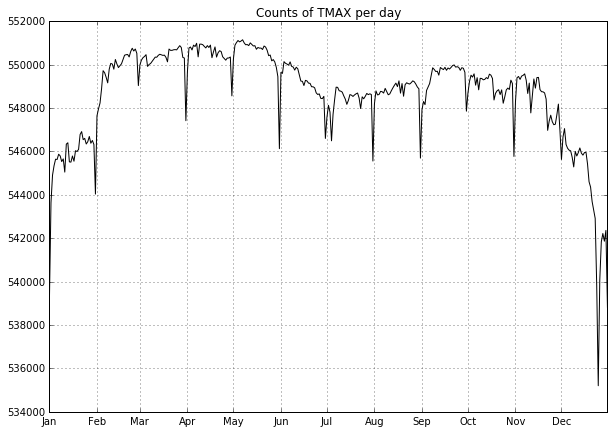

In [11]:
STAT,STAT_description=pickle.load(open(data_dir+'/STAT.pickle','r'))
Scalars=['mean','std','low1000','low100','high100','high1000']
for meas in STAT.keys():
    !grep $meas '../../Data/Weather/ghcnd-readme.txt'
    S=STAT[meas]
    for scalar in Scalars:
        print '%s:%f'%(scalar,S[scalar]),
    print

def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7),col='black'):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot_date(yearday,T, '-',color=col);
    plt.gca().xaxis.set_major_formatter( DateFormatter('%b') )
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

YearlyPlots(STAT['TMAX']['NE'], 'Counts of TMAX per day')

## The sudden dip of counts at the end of a month may only be in a specific timeframe (range of years).

I have plotted the counts for each day of the year for 16 year timeframe. From the plots, we can observe that till the end of the 20th century there was a dip in counts at the end of every month. But as we entered into the 21st century, the story begins to change. We see that till the month of August there was no dip at the end of month. This shows that there is some merit in the hypothesis that the dip was specific to some timeframe (in this case the period before 21st century). But we cannot afford to let go the data before the year 2000 to negate this effect, so we will have to find some other alternative to remove this effect.

The next task is to find out if the dip was due to some specific stations or was general to all stations before the year 2000. Before we jump into this task, here is one observation from the plots below. As we are moving forward in time (16 year timeframe in the plots below), we see that the total count of measurement in the timeframe increases. This implies that the number of stations kept increasing with time. However, the problem of count dip at the end of every month remained as it is. This gives us some intuition that as the total number of stations increased, the number of bad stations responsible for this effect also increase proportionally.

In [12]:
Data=pickle.load(open('../../Data/Weather/extra_year.pickle','r'))
Snwd_Data=pickle.load(open('../../Data/Weather/snwd_extra_year.pickle','r'))
Station=pickle.load(open('../../Data/Weather/extra_station.pickle','r'))
Snwd_Station=pickle.load(open('../../Data/Weather/snwd_extra_station.pickle','r'))

In [13]:
year=[x[0] for x in Data]
min_year=int(np.min(year))
max_year=int(np.max(year))
print min_year,max_year

rdd=sc.parallelize(Data)

1840 2013


Total count between 1840 to 1855: 6055
Total count between 1856 to 1871: 30755
Total count between 1872 to 1887: 419043
Total count between 1888 to 1903: 7545836
Total count between 1904 to 1919: 16280261
Total count between 1920 to 1935: 19119810
Total count between 1936 to 1951: 25688511
Total count between 1952 to 1967: 35673531
Total count between 1968 to 1983: 37439532
Total count between 1984 to 1999: 39934140
Total count between 2000 to 2015: 38483079


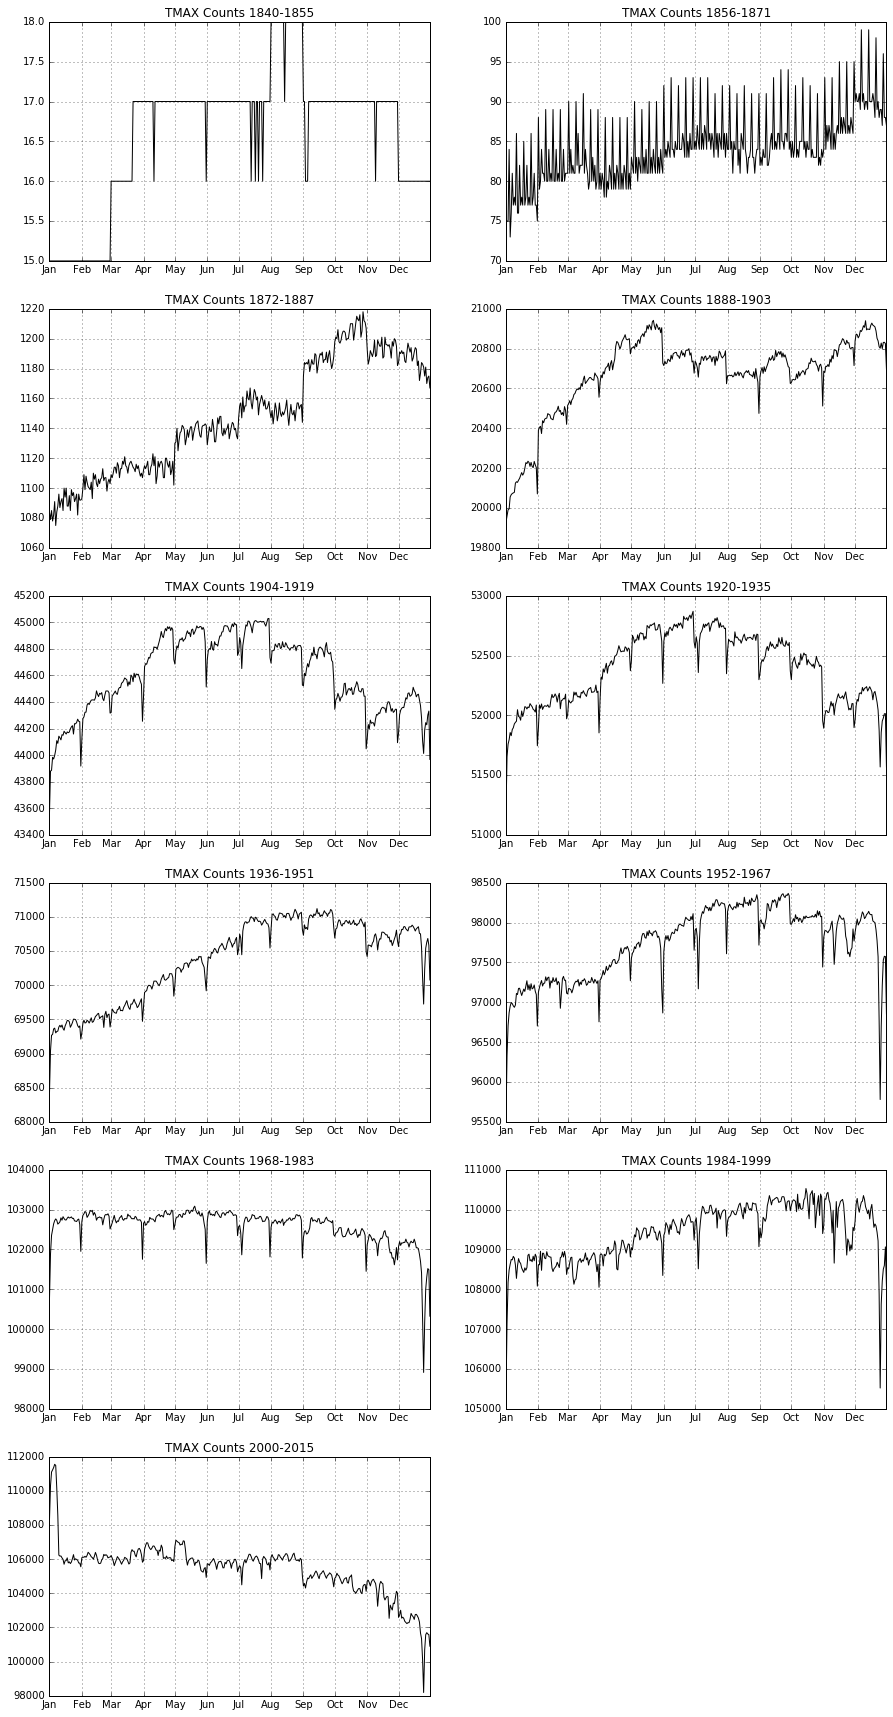

In [14]:
figure(figsize=(15,30))
offset=1
low_year=min_year
year_offset=16
while low_year<max_year:
    subplot(6,2,offset)
    offset+=1
    year=range(low_year,low_year+year_offset)
    y=rdd.filter(lambda (k,v):k in year).map(lambda (k,v):v).reduce(lambda x,y:x+y)
    ttl='TMAX Counts '+str(year[0])+'-'+str(year[-1])
    print 'Total count between %d to %d: %d'%(year[0],year[-1],sum(y))
    YearlyPlots(y,ttl)
    low_year=low_year+year_offset

## Remove stations responsible for sudden dip at the month end

Now we will remove the stations responsible for sudden dip at the month end. To find the stations responsible for these dips we compute the gradient at the last day of every month. The gradient at any point is defined as follows:
$$Gradient(x)=A[x+2]+A[x-2]-2A[x]$$

I have taken the mean of the gradients at month end for every station and filtered out the stations having gradient greater than a particular value (slack). As the value of slack increases the data loss decreases, which can be seen from the plots below. For slack=1.5 (last 2 plots), it is observed that if we are ready to throw away 15% of the data or the measurements 1330 stations out of 19937, then we can control sudden dips at the month end to a large extent. 

The plot on the left shows the good stations (which doesn't have much of a dip at month end) and the right shows the bad stations.

In [43]:
month_end=[30,58,89,119,150,180,211,242,272,303,333,364]
def compute_gradient(all_day,last_day):
    last_day_counts=[all_day[(i+2)%365]+all_day[i-2]-2*all_day[i] for i in last_day]
    return np.mean(last_day_counts)

Total stations: 19937
Total no. of measurements in all stations: 220620553

Gradient slack: 0.750000

TMAX Count for station having no dip: 16416
Total no. of measurements for stations with no dip: 142728553

TMAX Count for station having dip: 3521
Total no. of measurements for stations with dip: 77892000

Gradient slack: 1.000000

TMAX Count for station having no dip: 17416
Total no. of measurements for stations with no dip: 162164539

TMAX Count for station having dip: 2521
Total no. of measurements for stations with dip: 58456014

Gradient slack: 1.250000

TMAX Count for station having no dip: 18135
Total no. of measurements for stations with no dip: 176527109

TMAX Count for station having dip: 1802
Total no. of measurements for stations with dip: 44093444

Gradient slack: 1.500000

TMAX Count for station having no dip: 18607
Total no. of measurements for stations with no dip: 187891170

TMAX Count for station having dip: 1330
Total no. of measurements for stations with dip: 327293

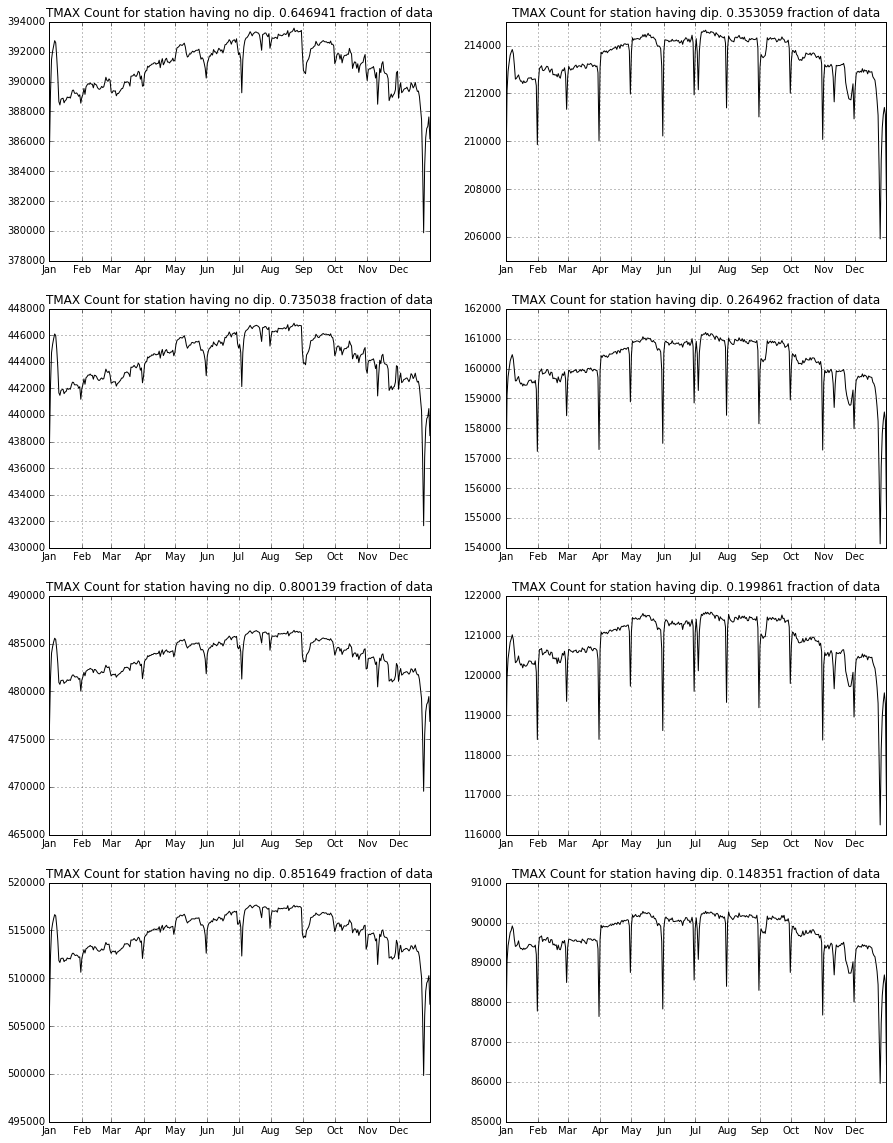

In [47]:
station_rdd=sc.parallelize(Station).cache()
dip_offset_list=[0.75,1,1.25,1.5]
offset=1

print 'Total stations: %d' %(station_rdd.count())
tc=station_rdd.flatMap(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total no. of measurements in all stations: %d\n' %(tc)

figure(figsize=(15,30))

for dip_offset in dip_offset_list:
    print 'Gradient slack: %f\n' %(dip_offset)
    no_dip_rdd=station_rdd.filter(lambda (k,v): compute_gradient(v,month_end)<dip_offset).cache()
    subplot(6,2,offset)
    total_count=no_dip_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
    print 'TMAX Count for station having no dip: %d' %(no_dip_rdd.count())
    print 'Total no. of measurements for stations with no dip: %d\n' %(sum(total_count))
    ttl='TMAX Count for station having no dip. %f fraction of data' %(1.0*sum(total_count)/tc)
    YearlyPlots(total_count,ttl)

    dip_rdd=station_rdd.filter(lambda (k,v): compute_gradient(v,month_end)>=dip_offset).cache()
    subplot(6,2,offset+1)
    total_count=dip_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
    print 'TMAX Count for station having dip: %d' %(dip_rdd.count())
    print 'Total no. of measurements for stations with dip: %d\n' %(sum(total_count))
    ttl='TMAX Count for station having dip. %f fraction of data' %(1.0*sum(total_count)/tc)
    YearlyPlots(total_count,ttl)
    
    offset=offset+2

## Plot good and bad stations on map using Bokeh

In the following code, I have plotted good (in red color) and the bad (in blue color) stations on map using Bokeh. As we can see that there is no pattern in which good and bad stations are spread on the map. Hence, we can say that the stations responsible for the month end dip are not because of their location, i.e. they seem to be uniformly distributed everywhere.
<img src="tmax_good_bad1.png">

In [39]:
import numpy as np
from bokeh.plotting import figure, output_notebook, show, output_file
import matplotlib.cm as cm
import matplotlib as mpl
from bokeh.plotting import hplot
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, PreviewSaveTool
)

stations_all=pickle.load(open(data_dir+'/stations.pkl','r'))

def get_lat_lon(stations,points):
    #this code is using pandas dataframes
    lons=stations.ix[:,'longitude'].values
    lats=stations.ix[:,'latitude'].values
    elev=stations.ix[:,'elevation'].values
    station_names=stations.index.values
    ll=len(lons)
    lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
    select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
    print sum(select)
    station_names=station_names[select]
    lons=lons[select]
    lats=lats[select]
    elev=elev[select]
    elev=[min(3000,max(e,0))/3000. for e in elev]
    print len(lons),len(lats),len(station_names),len(elev)
    
    arr = np.array(zip(lons, lats, elev))
    indices = np.random.choice(xrange(len(arr)), points, replace=False)
    new_arr = arr[indices]
    lons = new_arr[:,0]
    lats = new_arr[:,1]
    elev = new_arr[:,2]
    
    return lons,lats,elev

stations_dip=stations_all.loc[dip_rdd.map(lambda (k,v):k).collect()]
stations_no_dip=stations_all.loc[no_dip_rdd.map(lambda (k,v):k).collect()]

lons_dip,lats_dip,elev_dip=get_lat_lon(stations_dip,1300)
lons_no_dip,lats_no_dip,elev_no_dip=get_lat_lon(stations_no_dip,2000)

1330
1330 1330 1330 1330
18607
18607 18607 18607 18607


In [40]:
variable1 = elev_no_dip
variable2 = elev_dip

colors1=['red' for s in variable1]
colors2=['blue' for s in variable2]

output_file("plot.html", title="USA Elevation plot", mode="cdn")

from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, PreviewSaveTool
)

map_options = GMapOptions(lat=37.09024, lng=-95.712891, map_type="terrain", zoom=3)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)


source1 = ColumnDataSource(
    data=dict(
        lat=list(lats_no_dip)+list(lats_dip),
        lon=list(lons_no_dip)+list(lons_dip),
        col=colors1+colors2
    )
)

circle = Circle(x="lon", y="lat", size=5, fill_color="col", fill_alpha=1, line_color=None,)
plot.add_glyph(source1, circle) # Plot for variable 1
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), PreviewSaveTool())

p = hplot(plot)
show(p)


## Dip at the begining and end of year

Similar to the previous approach, when I tried to remove stations by computing gradient on 25th December and 31st December, I observed that data loss was quite high (~40%) even after increasing the slack value. This can be seen in the plots below. This shows that removing dips at the time of holiday season is inevitable, as most of the stations don't work at their full capacity at that time of the year. 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Total stations: 19937
Total no. of measurements in all stations: 220620553

Gradient slack: 0.750000

TMAX Count for station having no dip: 13807
Total no. of measurements for stations with no dip: 116734833

TMAX Count for station having dip: 6130
Total no. of measurements for stations with dip: 103885720

Gradient slack: 1.000000

TMAX Count for station having no dip: 13807
Total no. of measurements for stations with no dip: 116734833

TMAX Count for station having dip: 6130
Total no. of measurements for stations with dip: 103885720

Gradient slack: 1.250000

TMAX Count for station having no dip: 15511
Total no. of measurements for stations with no dip: 137192966

TMAX Count for station having dip: 4426
Total no. of measurements for stations with dip: 83427587

Gradient slack: 1.500000

TMAX Count for station having no dip: 15511
Total no. of measurements for stations with no dip: 137192966

TMAX Count for station having dip: 4426
Total no. of measurements for stations with dip: 8342

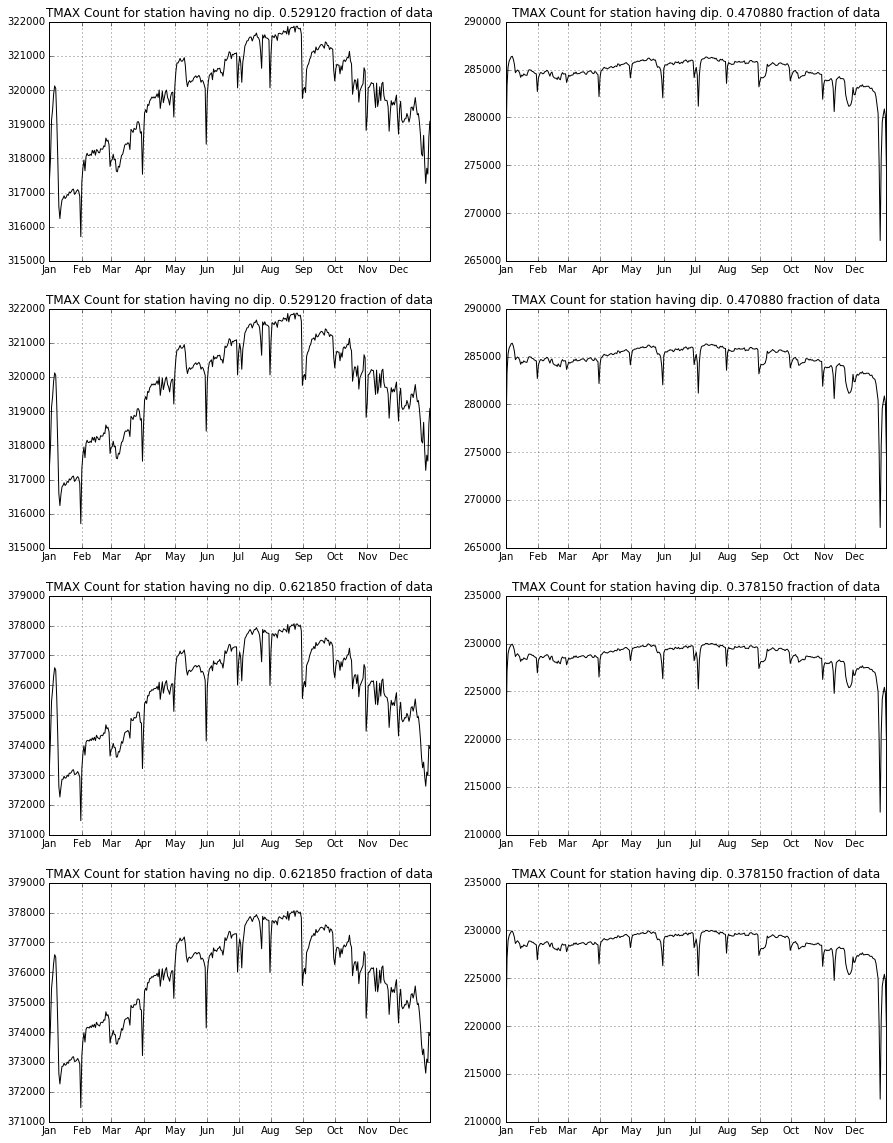

In [21]:
%pylab inline
dec_25=[358,364]
station_rdd=sc.parallelize(Station).cache()
dip_offset_list=[0.75,1,1.25,1.5]
offset=1

print 'Total stations: %d' %(station_rdd.count())
tc=station_rdd.flatMap(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total no. of measurements in all stations: %d\n' %(tc)

figure(figsize=(15,30))

for dip_offset in dip_offset_list:
    print 'Gradient slack: %f\n' %(dip_offset)
    no_dip_rdd=station_rdd.filter(lambda (k,v): compute_gradient(v,dec_25)<dip_offset).cache()
    subplot(6,2,offset)
    total_count=no_dip_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
    print 'TMAX Count for station having no dip: %d' %(no_dip_rdd.count())
    print 'Total no. of measurements for stations with no dip: %d\n' %(sum(total_count))
    ttl='TMAX Count for station having no dip. %f fraction of data' %(1.0*sum(total_count)/tc)
    YearlyPlots(total_count,ttl)

    dip_rdd=station_rdd.filter(lambda (k,v): compute_gradient(v,dec_25)>=dip_offset).cache()
    subplot(6,2,offset+1)
    total_count=dip_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
    print 'TMAX Count for station having dip: %d' %(dip_rdd.count())
    print 'Total no. of measurements for stations with dip: %d\n' %(sum(total_count))
    ttl='TMAX Count for station having dip. %f fraction of data' %(1.0*sum(total_count)/tc)
    YearlyPlots(total_count,ttl)
    
    offset=offset+2

# Task 2: Analysis of Counts per day for SNWD

The following plot shows the counts per day for SNWD measured by all stations. We want to analyze why there is a dip in the count towards the begining and end of the year.

194366707


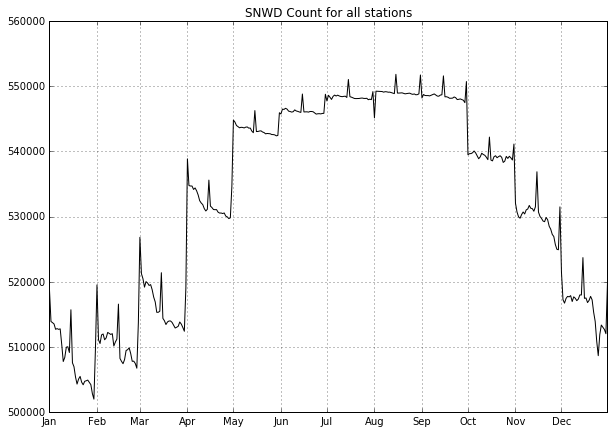

In [22]:
snwd_station_rdd=sc.parallelize(Snwd_Station)
total_count=snwd_station_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
ttl='SNWD Count for all stations'
YearlyPlots(total_count,ttl)
print np.sum(total_count)

## Divide the stations into 3 subsets
In the following plots, the stations are divided into three subsets: having no count dip, having some dip and having huge dip at the begining and end of the year. The partition is done by comparing the mean of the counts for the months of January and December with other months.

Here are some of the observations from the plot: 
1. Out of 34933 stations, about 43% of the stations have no dip in winter but has count dips in the mid months, about 44% of the stations have some dip around Dec-Jan whereas only 13% of the stations have huge dips in the count during Dec-Jan.
2. The most interesting observation is that each subset of stations contributes about equally to the total count (i.e. one-third). It is surprising that even though there are only 13% stations which have huge dips but they still have equal contribution towards total count.

This means that these stations with a huge dip are the most active ones. So, the question is why are these stations more active than other stations. One possible hypothesis could be the geographical location of these stations. To further investigate this, I have plotted these stations on map using Bokeh. 

(Please scroll below for further analysis)

In [23]:
def compare_with_mean(all_day):
    jan=[all_day[i] for i in all_day[:31]]
    dec=[all_day[i] for i in all_day[-31:]]
    jan_dec=jan+dec
    other_month=[all_day[i] for i in range(31,365-31)]
    return np.mean(jan_dec)-np.mean(other_month)

Populating the interactive namespace from numpy and matplotlib
Total number of stations: 34933
Total counts across all stations: 194366707

Total number of stations having no dip in Dec and Jan: 14975
Total counts across stations having no dip in Dec and Jan: 62804172

Total number of stations having small dip in Dec and Jan: 15552
Total counts across stations having small dip in Dec and Jan: 67783927

Total number of stations having huge dip in Dec and Jan: 4406
Total counts across stations having huge dip in Dec and Jan: 63778608



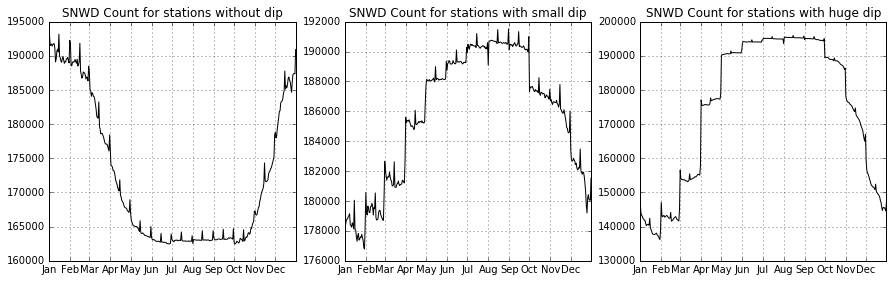

In [24]:
%pylab inline

total_count=snwd_station_rdd.flatMap(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total number of stations: %d' %(snwd_station_rdd.count())
print 'Total counts across all stations: %d\n' %(total_count)
dip_offset1=0
dip_offset2=-3
figure(figsize=(15,30))


subplot(6,3,1)
reduced_snwd_station_rdd=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)>=dip_offset1)
total_count=reduced_snwd_station_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total number of stations having no dip in Dec and Jan: %d' %(reduced_snwd_station_rdd.count())
print 'Total counts across stations having no dip in Dec and Jan: %d\n' %(np.sum(total_count))
ttl='SNWD Count for stations without dip'
YearlyPlots(total_count,ttl)

subplot(6,3,2)
reduced_snwd_station_rdd=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)>=dip_offset2 and compare_with_mean(v)<dip_offset1)
total_count=reduced_snwd_station_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total number of stations having small dip in Dec and Jan: %d' %(reduced_snwd_station_rdd.count())
print 'Total counts across stations having small dip in Dec and Jan: %d\n' %(np.sum(total_count))
ttl='SNWD Count for stations with small dip'
YearlyPlots(total_count,ttl)


subplot(6,3,3)
reduced_snwd_station_rdd=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)<dip_offset2)
total_count=reduced_snwd_station_rdd.map(lambda (k,v):v).reduce(lambda x,y:x+y)
print 'Total number of stations having huge dip in Dec and Jan: %d' %(reduced_snwd_station_rdd.count())
print 'Total counts across stations having huge dip in Dec and Jan: %d\n' %(np.sum(total_count))
ttl='SNWD Count for stations with huge dip'
YearlyPlots(total_count,ttl)

## Plotting stations on map using Bokeh
In the following code, I am plotting the geographical locations of these three subsets of stations on map. The three subset of stations: having no dip (green), some dip (blue) and huge dip (red); are plotted from left to right respectively.

<img src="no_some_huge.png">

We can observe following things from the plot:
1. Stations responsible for huge dips in the winter (in red) are mostly located in the north (colder regions). This can be due to the heavy snowfall in these regions which could prevent these stations from functioning at their full capacity. This also explains why these stations are the most active ones, as the snow depth measurement for these areas are more important than other warmer areas like San Diego.

2. Stations having no dips in winter (in green) are mostly concentrated in the developed states like New York, Washington, etc. This makes a lot of sense as these states are expected to have better resources to deal with situations that prevent these stations from getting affected from the snow. But the reason why these stations have dip in the min-months is still not investigated.

3. Finally, the stations having small dips (in blue) are located all across the country but mostly concentrated in the warmer regions (mostly in the southern part). 

The next question is why is there such a huge dip in counts in the months of December and January. This can be explaied by the plot of average snow depth for every day of the year, shown below. As it can be seen from the plot, the snow depth begins to rise from the start of the October, reaches its maxima at the end of January and then slowly starts to decrease. This is exactly the opposite behavior we observed in the plot of counts for stations with huge dip. This explains that as the snow depth starts to rise, these stations stops functioning at their full potential because of obvious logistic problems, and that is why there are low counts at the begining and end of the year.

Populating the interactive namespace from numpy and matplotlib


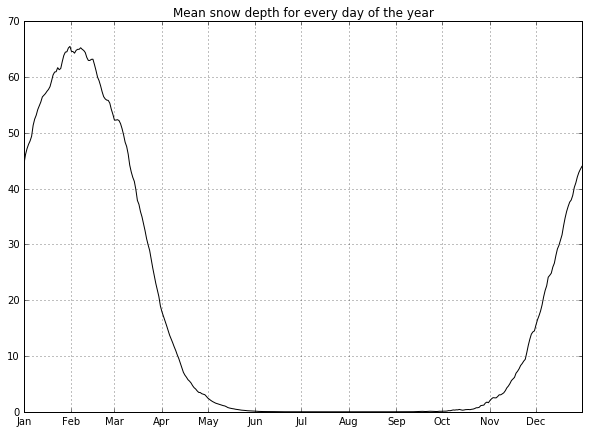

In [25]:
%pylab inline

YearlyPlots(STAT['SNWD']['Mean'],'Mean snow depth for every day of the year')

In [26]:
stations_all=pickle.load(open(data_dir+'/stations.pkl','r'))

In [27]:
snwd_station_no_dip=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)>=dip_offset1)\
                                    .map(lambda (k,v):k).collect()
snwd_station_some_dip=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)>=dip_offset2 and compare_with_mean(v)<dip_offset1)\
                                    .map(lambda (k,v):k).collect()
snwd_station_huge_dip=snwd_station_rdd.filter(lambda (k,v): compare_with_mean(v)<dip_offset2)\
                                    .map(lambda (k,v):k).collect()

In [28]:
import numpy as np
from bokeh.plotting import figure, output_notebook, show, output_file
import matplotlib.cm as cm
import matplotlib as mpl
from bokeh.plotting import hplot
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, PreviewSaveTool
)

def get_lat_lon(stations):
    #this code is using pandas dataframes
    lons=stations.ix[:,'longitude'].values
    lats=stations.ix[:,'latitude'].values
    elev=stations.ix[:,'elevation'].values
    station_names=stations.index.values
    ll=len(lons)
    lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
    select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
    print sum(select)
    station_names=station_names[select]
    lons=lons[select]
    lats=lats[select]
    elev=elev[select]
    elev=[min(3000,max(e,0))/3000. for e in elev]
    print len(lons),len(lats),len(station_names),len(elev)
    
    arr = np.array(zip(lons, lats, elev))
    indices = np.random.choice(xrange(len(arr)), 4000, replace=False)
    new_arr = arr[indices]
    lons = new_arr[:,0]
    lats = new_arr[:,1]
    elev = new_arr[:,2]
    
    return lons,lats,elev

stations_huge_dip=stations_all.loc[snwd_station_huge_dip]
stations_some_dip=stations_all.loc[snwd_station_some_dip]
stations_no_dip=stations_all.loc[snwd_station_no_dip]

lons_huge_dip,lats_huge_dip,elev_huge_dip=get_lat_lon(stations_huge_dip)
lons_some_dip,lats_some_dip,elev_some_dip=get_lat_lon(stations_some_dip)
lons_no_dip,lats_no_dip,elev_no_dip=get_lat_lon(stations_no_dip)

4406
4406 4406 4406 4406
15552
15552 15552 15552 15552
14975
14975 14975 14975 14975


In [36]:
variable1 = elev_no_dip
variable2 = elev_some_dip
variable3 = elev_huge_dip

colors1=['green' for s in variable1]
colors2=['blue' for s in variable2]
colors3=['red' for s in variable3]

output_file("plot.html", title="USA Elevation plot", mode="cdn")

from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, PreviewSaveTool
)

map_options = GMapOptions(lat=37.09024, lng=-95.712891, map_type="terrain", zoom=3)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)

plot2 = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)

plot3 = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)


source1 = ColumnDataSource(
    data=dict(
        lat=lats_no_dip,
        lon=lons_no_dip,
        col=colors1
    )
)

source2 = ColumnDataSource(
    data=dict(
        lat=lats_some_dip,
        lon=lons_some_dip,
        col=colors2
    )
)

source3 = ColumnDataSource(
    data=dict(
        lat=lats_huge_dip,
        lon=lons_huge_dip,
        col=colors3
    )
)
circle = Circle(x="lon", y="lat", size=2, fill_color="col", fill_alpha=1, line_color=None,)
plot.add_glyph(source1, circle) # Plot for variable 1
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), PreviewSaveTool())

plot2.add_glyph(source2, circle) # Plot for variable 2
plot2.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), PreviewSaveTool())

plot3.add_glyph(source3, circle) # Plot for variable 2
plot3.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), PreviewSaveTool())

p = hplot(plot,plot2, plot3)
show(p)


In [33]:
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, PreviewSaveTool
)

map_options = GMapOptions(lat=37.09024, lng=-95.712891, map_type="terrain", zoom=3)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)


source1 = ColumnDataSource(
    data=dict(
        lat=list(lats_some_dip)+list(lats_huge_dip),
        lon=list(lons_some_dip)+list(lons_huge_dip),
        col=colors3+colors1
    )
)

circle = Circle(x="lon", y="lat", size=5, fill_color="col", fill_alpha=1, line_color=None,)
plot.add_glyph(source1, circle) # Plot for variable 1
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), PreviewSaveTool())


p = hplot(plot)
show(p)
